# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

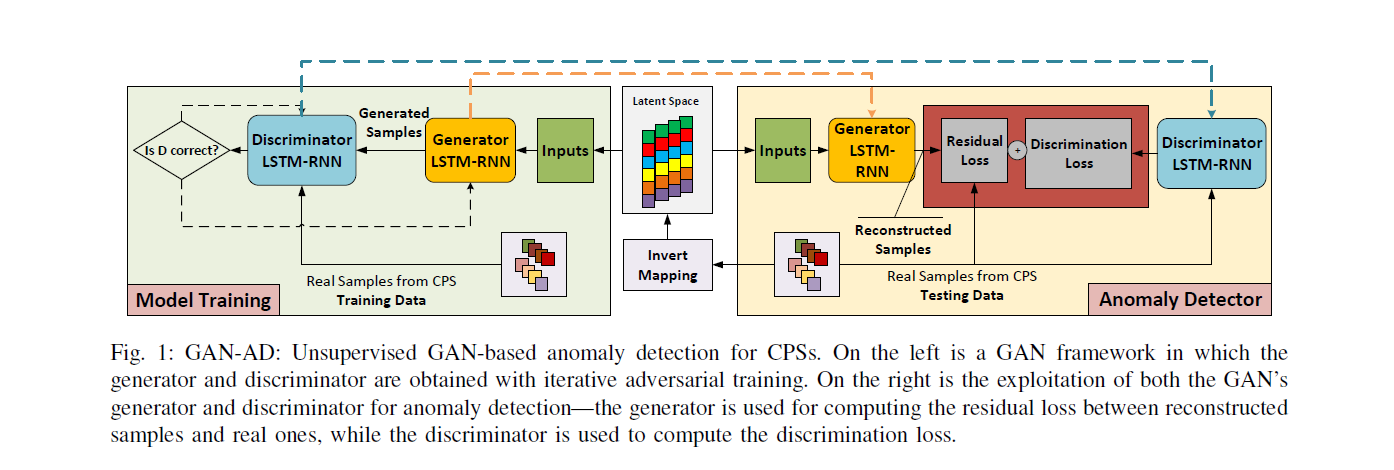

In [1]:
import os
import pandas as pd
import numpy as np
from time_series_anomaly_detection.detector import GAN_AD
import random
from datetime import date
import matplotlib.pyplot as plt

# Skoltech Anomaly Benchmark (SKAB) dataset
https://github.com/waico/SKAB

## Load and split data

In [2]:
# single multivariate time series
df_anomaly_free = pd.read_csv("../datasets/skab/anomaly-free/anomaly-free.csv", index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

In [3]:
ratio = 0.75
split = int(len(df_anomaly_free)*ratio)
df_anomaly_free, df_test = df_anomaly_free.iloc[:split,:].reset_index(drop=True), df_anomaly_free.iloc[split:,:].reset_index(drop=True)

In [4]:
df_anomaly_free.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.211477,0.269542,2.532384,0.111784,89.700982,28.138902,228.435041,124.765474
std,0.004761,0.004007,5.341825,0.253411,0.648544,0.672366,12.242058,1.731301
min,0.198511,0.260767,0.855284,-0.929070,88.546100,26.765800,1.336380,118.000000
25%,0.209461,0.266371,2.129020,0.054711,89.213800,27.600425,222.478000,123.335000
50%,0.212496,0.268205,2.545025,0.054711,89.579700,28.271000,228.886000,125.331000
75%,0.214572,0.273093,2.731903,0.382638,90.152500,28.702025,234.830250,126.000000
max,0.222114,0.280214,230.819000,1.366420,91.724900,29.075200,252.806000,128.351000


In [5]:
ratio = 0.5
split = int(len(df_test)*ratio)
df_anomaly_free_test, df_with_anomalies = df_test.iloc[:split,:].reset_index(drop=True), df_test.iloc[split:,:].reset_index(drop=True)

In [6]:
# insert dummy fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, [0,1,4]] = df_with_anomalies.iloc[anomaly_index, [0,1,4]] * 0.95
df_with_anomalies.iloc[anomaly_index, [2,6]] = df_with_anomalies.iloc[anomaly_index, [2,6]] * 1.1
df_with_anomalies.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,0.211770,0.264146,2.662389,0.108529,87.907734,29.342310,233.377190,126.050878
std,0.005607,0.006155,7.388220,0.247501,1.793900,0.041834,15.718574,0.669431
min,0.186048,0.246563,0.893839,-0.601143,83.839780,29.247400,2.611422,123.000000
25%,0.209330,0.262810,2.172702,0.054711,88.403150,29.322000,225.114000,125.677000
50%,0.212274,0.265243,2.573680,0.054711,88.634350,29.343700,231.399500,126.000000
75%,0.215435,0.267920,2.797279,0.382638,88.980650,29.354700,242.537000,126.677000
max,0.225967,0.276206,255.230800,0.710565,89.538500,29.522100,276.999800,127.678000


In [7]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS'])

## Model's parameters settings

In [8]:
# values selected based on experiments
window_size = 16
shift = 5
batch_size = 32
latent_dim = 2 
n_features = df_anomaly_free.shape[1]

## Training

In [9]:
gan_ad = GAN_AD(window_size, shift, batch_size, latent_dim, n_features)
gan_ad.fit(df_anomaly_free, 10000, save_checkpoints=True, enable_prints=True)
# gan_ad.save_model("gan_ad_" + str(date.today()) + ".h5")

KeyboardInterrupt: 

## Loading best weights

7000 . epoch

Batch loss (disc_loss, gen_loss) : [0.21547717 3.9397886 ]

7500 . epoch

Batch loss (disc_loss, gen_loss) : [0.05491132 4.837315  ]

8000 . epoch

Batch loss (disc_loss, gen_loss) : [0.34914508 3.4787216 ]

8500 . epoch

Batch loss (disc_loss, gen_loss) : [0.80346507 2.6210155 ]

9000 . epoch

Batch loss (disc_loss, gen_loss) : [0.2298915 3.904429 ]

In [10]:
gan_ad.load_weights("gan_ad_2021-05-01_epoch_9000.h5")
gan_ad.fit_scaler(df_anomaly_free)

## Evaluation with anomaly free (training) data

In [11]:
# less than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+window_size-5]))

Not enough data to predict anomaly scores.


loss celkovo:  0.42949956734833822
loss celkovo:  0.0641030777019032
loss celkovo:  0.064102605542403088
loss celkovo:  0.064102138975854719
loss celkovo:  0.064101700417795726
final loss:  0.0641543124738745
[[0.28698045 1.46874499]
 [-0.8960917 1.25434828]
 [-0.617373824 2.77915597]
 ...
 [-2.76321268 0.148388669]
 [-0.413576722 0.805675387]
 [0.461243242 -1.28048956]]
sample


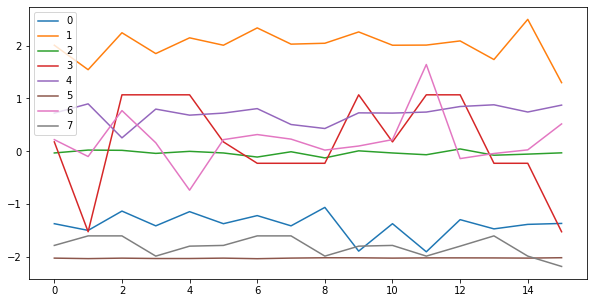

generated_sample


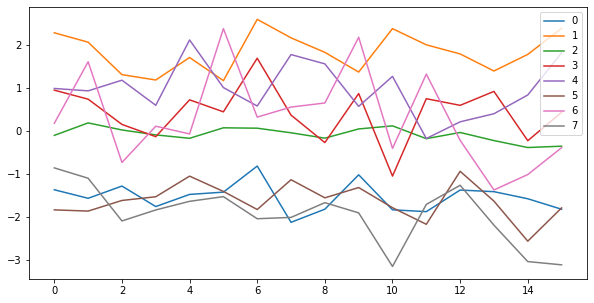

residuals: 
tf.Tensor(
[2.53904381 5.42834101 5.32410112 3.15493881 4.51746613 4.57413372
 3.63200604 4.36921053 3.58856123 5.03396152 4.98801213 2.12501806
 3.24717013 4.47324991 3.96361267 6.82686643], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.71609133], shape=(1,), dtype=float32)
idem vlozit nan
Anomaly free (training) data with NaNs - anomaly scores
0          NaN
1     2.856125
2     2.804005
3     1.719424
4     2.400687
5          NaN
6     1.957957
7     2.326560
8     1.936235
9     2.658935
10         NaN
11    1.204463
12    1.765539
13    2.378579
14    2.123761
15    3.555388
dtype: float64


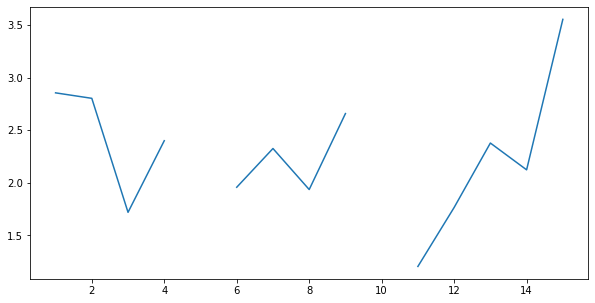

In [17]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_anomaly_free[0:0+window_size].copy())
window_with_nan.iloc[[0,5,10], [2,5]] = np.nan
# display(windows_with_nan)

anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
print('Anomaly free (training) data with NaNs - anomaly scores')
print(anomaly_scores)
anomaly_scores.plot(figsize=(10,5))
plt.show()

Ignoring last 8 samples (incomplete window).
loss celkovo:  0.37365971058049424
loss celkovo:  0.051378628531558612
loss celkovo:  0.051378240697181249
loss celkovo:  0.0513778590792581
loss celkovo:  0.051377496114599054
final loss:  0.0543928080965846
[[0.743935406 -0.246883169]
 [0.0381919928 0.459125072]
 [0.865259886 -0.583210409]
 ...
 [1.2535969 0.640384912]
 [-1.02600241 -2.28967166]
 [-2.57132268 -0.475592196]]
sample


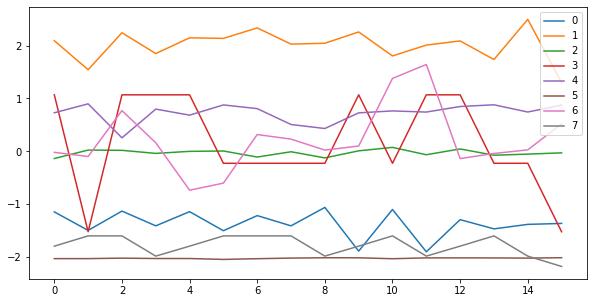

generated_sample


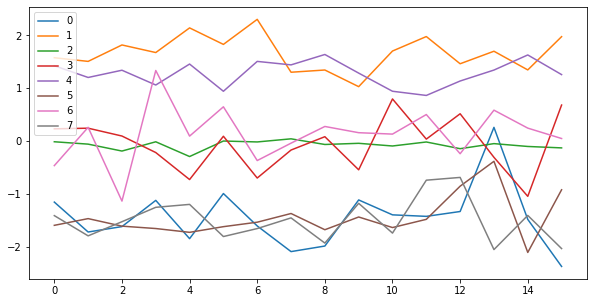

residuals: 
tf.Tensor(
[3.44061456 3.52676271 5.56794236 4.29895878 5.29386606 3.07915177
 2.92647434 3.50765837 3.8319009  5.46755971 3.55075426 4.61430169
 4.06532614 5.04071214 3.88786833 6.07095872], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.712355], shape=(1,), dtype=float32)
loss celkovo:  0.21423636672759677
loss celkovo:  0.063002186458866169
loss celkovo:  0.0630010801335162
loss celkovo:  0.063000138023855637
loss celkovo:  0.062999294471447614
final loss:  0.064795904811766558
[[-1.36631525 -0.385425955]
 [-1.53198671 0.599791467]
 [0.730478168 -1.19765687]
 ...
 [0.220064893 -1.15432727]
 [0.178455144 0.314359546]
 [2.05268288 -0.401301354]]
sample


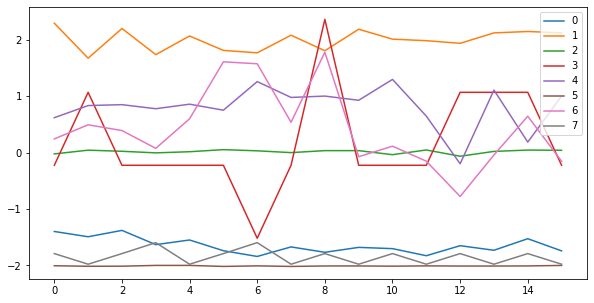

generated_sample


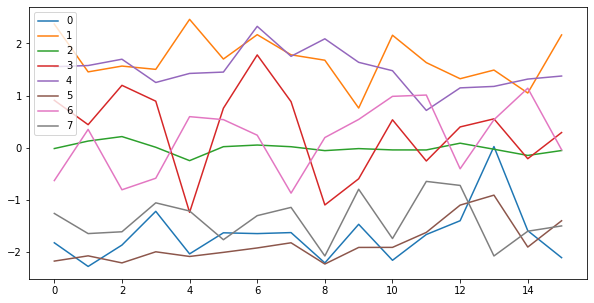

residuals: 
tf.Tensor(
[4.16003862 3.00087353 5.16261205 3.44327555 3.60098557 3.02637663
 6.68070325 4.67040454 7.33308836 4.65818963 2.56451643 3.57177845
 5.36658233 4.80048418 4.55583683 2.57817746], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.8102212], shape=(1,), dtype=float32)
Anomaly free (training) data - anomaly scores


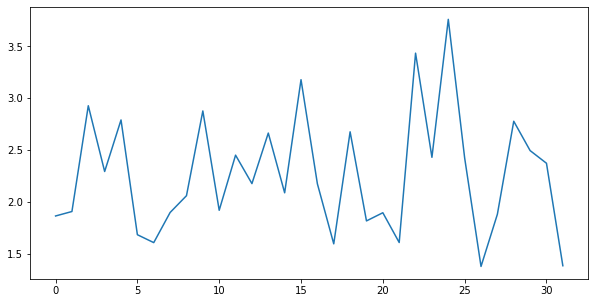

In [33]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+(2*window_size)+8]))
print('Anomaly free (training) data - anomaly scores')
anomaly_scores.plot(figsize=(10,5))
plt.show()

## Evaluation with anomaly free (test) data

loss celkovo:  0.15524802495094539
loss celkovo:  0.085595922029476829
loss celkovo:  0.085594603792512242
loss celkovo:  0.085593485776899264
loss celkovo:  0.085592495032870308
final loss:  0.085411449431956554
[[0.413427234 0.252561301]
 [-1.6263814 1.31265521]
 [-0.57408458 1.35309362]
 ...
 [-1.17626 -0.384935379]
 [-1.03348374 -0.418543249]
 [0.546298802 0.109506845]]
sample


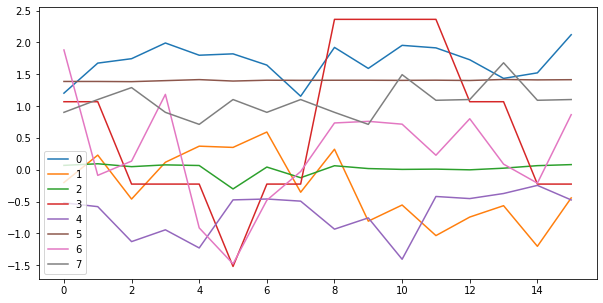

generated_sample


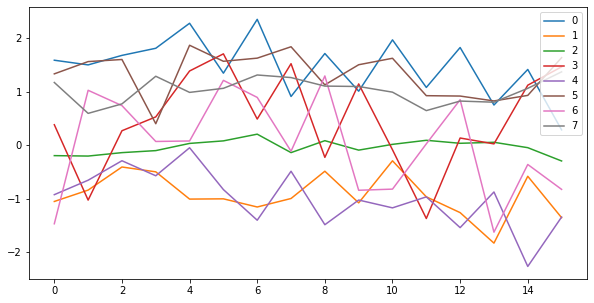

residuals: 
tf.Tensor(
[6.26673725 5.51253817 2.97833631 4.60397744 6.38709079 8.69513101
 6.26058121 3.33236049 5.22394984 4.53783091 5.22491539 6.40382433
 3.48414084 6.71579569 4.87363285 7.85712753], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6248704], shape=(1,), dtype=float32)
loss celkovo:  0.099881378579146571
loss celkovo:  0.071962783108146827
loss celkovo:  0.071962690920413672
loss celkovo:  0.07196258145704465
loss celkovo:  0.071962470463294681
final loss:  0.0674137906749818
[[0.0736823827 -0.794129908]
 [-0.179401442 0.468773097]
 [-1.94341993 1.24728334]
 ...
 [0.606280327 -0.175001055]
 [-1.05327022 0.914703071]
 [-1.84505534 0.869048119]]
sample


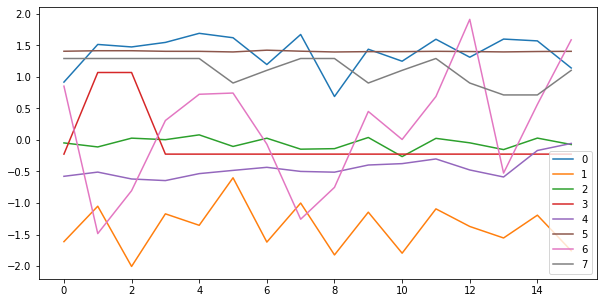

generated_sample


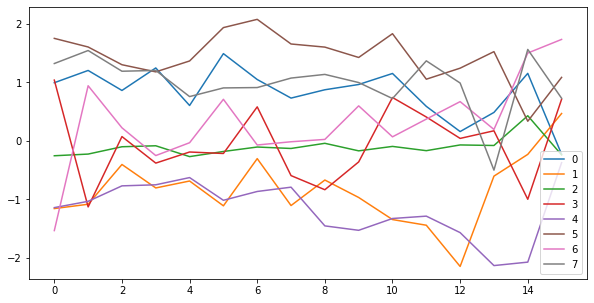

residuals: 
tf.Tensor(
[5.33352206 6.04883209 4.72692221 1.88244749 3.55472564 1.8354869
 3.68151342 3.43001164 4.130048   2.39605612 3.50887401 3.90755486
 4.79316161 6.14664471 7.31244453 5.85367194], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.7036141], shape=(1,), dtype=float32)
loss celkovo:  0.089262259224089452
loss celkovo:  0.075313606180885881
loss celkovo:  0.075313106089415577
loss celkovo:  0.075312635124614086
loss celkovo:  0.075312196966640724
final loss:  0.074900650875228542
[[-0.748627782 -0.146093905]
 [0.355556726 3.18031812]
 [-1.48653984 -0.0494725145]
 ...
 [1.29911029 -3.12069201]
 [-4.51100492 -0.647508442]
 [-1.64512455 3.92844868]]
sample


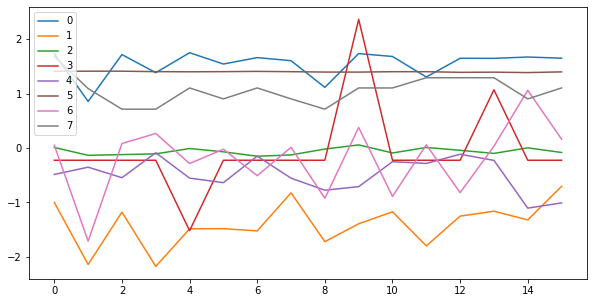

generated_sample


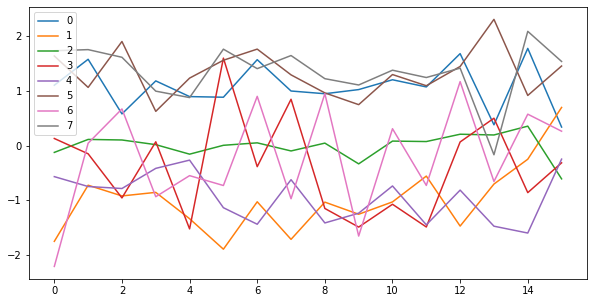

residuals: 
tf.Tensor(
[4.49184472 5.61863059 4.56995156 4.53055147 2.09884607 5.19560662
 4.30139163 4.50556179 5.2941654  8.3026051  3.70432238 5.11059687
 3.6630997  6.89780403 4.80044652 4.68082538], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.55724037], shape=(1,), dtype=float32)
Anomaly free (test) data - anomaly scores


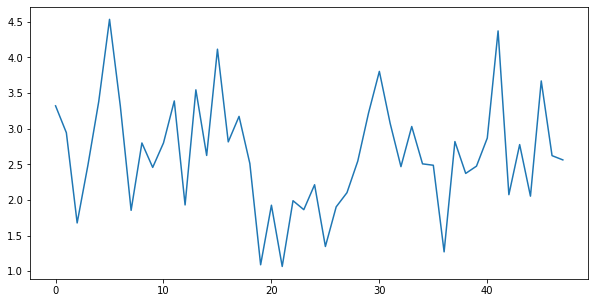

In [34]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:0+(3*window_size)]))
print('Anomaly free (test) data - anomaly scores')
anomaly_scores.plot(figsize=(10,5))
plt.show()

## Evaluation with data with anomalies

Window with anomalies


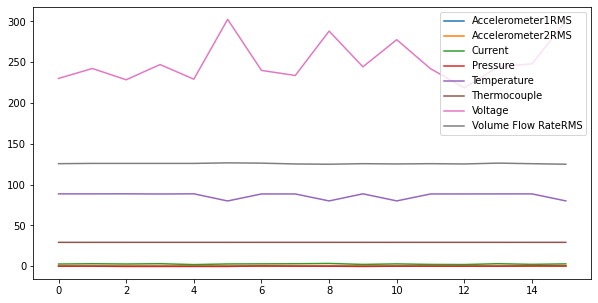

loss celkovo:  0.31816048240724154
loss celkovo:  0.29590894771517717
loss celkovo:  0.29590850845113975
loss celkovo:  0.29590806518620139
loss celkovo:  0.29590762741310894
final loss:  0.2952066257058007
[[-0.0463323146 0.686807632]
 [0.104786605 -0.913586318]
 [-0.440405458 1.07283223]
 ...
 [-1.80690944 -2.87387848]
 [0.0195818879 -0.881159961]
 [-1.26953208 -0.0872749388]]
sample


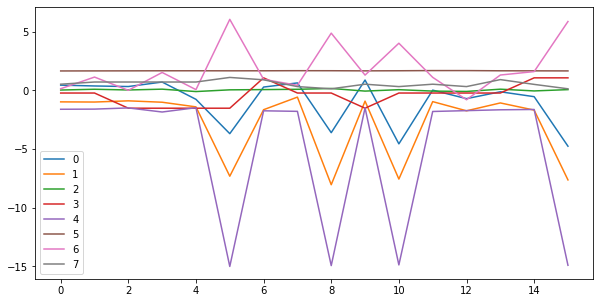

generated_sample


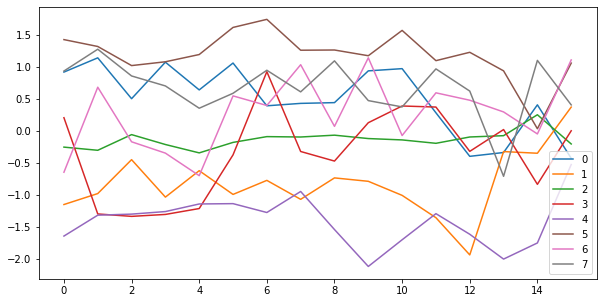

residuals: 
tf.Tensor(
[ 2.82897169  3.88608141  2.04288649  3.98478539  4.67108595 32.38364119
  2.4040835   3.13965712 31.39748504  3.22922135 30.30962085  3.44587127
  2.75278324  5.12840981  8.47457279 33.67911813], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.74716866], shape=(1,), dtype=float32)
Window with anomalies - anomaly scores


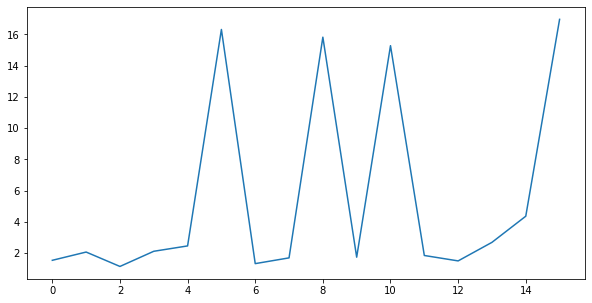

Window with anomalies - true labels


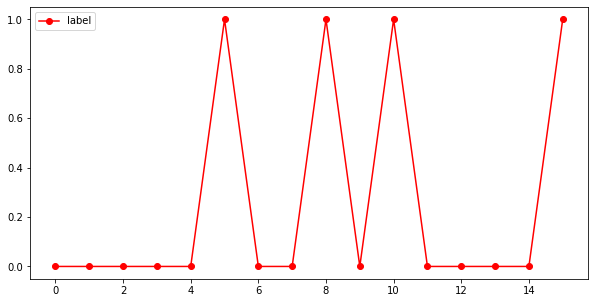

loss celkovo:  0.30771526380252168
loss celkovo:  0.29445841168509229
loss celkovo:  0.29424257526836894
loss celkovo:  0.29424251902229692
loss celkovo:  0.29424246672950183
final loss:  0.29424934571765515
[[-0.67409873 -0.306843519]
 [-0.502094507 1.89018667]
 [-1.78242326 0.901935339]
 ...
 [6.3295455 -0.051609017]
 [8.5787487 -2.97693801]
 [-2.7955606 -4.13431549]]
sample


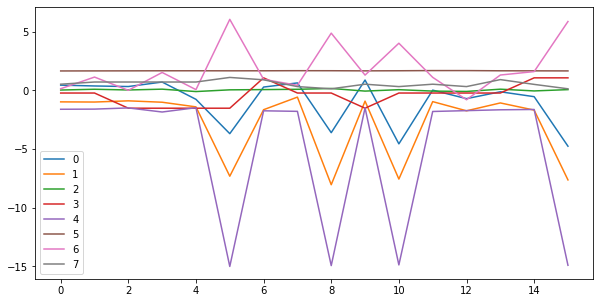

generated_sample


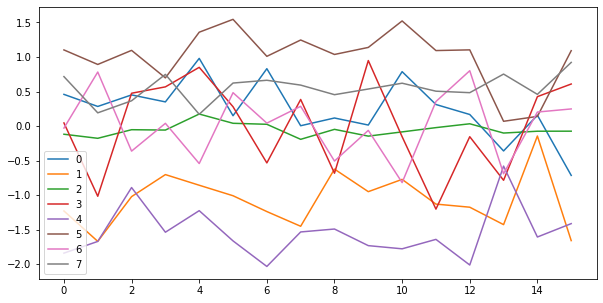

residuals: 
tf.Tensor(
[ 1.82632142  3.55060907  4.22406484  5.71824577  6.64759927 31.46633066
  4.69195208  3.50743354 31.59190829  5.59672318 30.73303193  3.00774382
  4.26258393  6.2035289   5.89798731 31.08228805], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.544721], shape=(1,), dtype=float32)
cross_entropy
0     0.131730
1     0.694618
2     0.850011
3     1.127123
4     1.267353
5     2.770136
6     0.945312
7     0.683782
8     2.774062
9     1.107242
10    2.746896
11    0.548995
12    0.858209
13    1.202793
14    1.155822
15    2.758032
dtype: float64
Window with anomalies - resulted labels


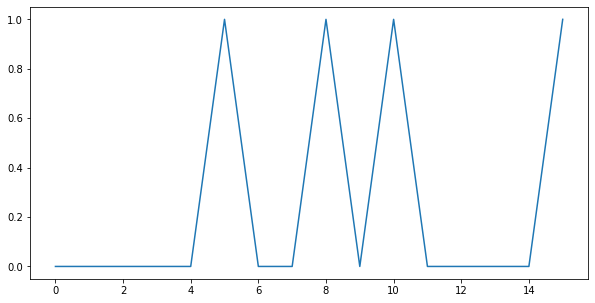

In [32]:
# one window
print('Window with anomalies')
window = pd.DataFrame(df_with_anomalies[i:i+window_size])
window.plot(figsize=(10,5))
plt.show()

anomaly_score = gan_ad.predict_anomaly_scores(pd.DataFrame(df_with_anomalies[i:i+window_size]))
print('Window with anomalies - anomaly scores')
anomaly_score.plot(figsize=(10,5))
plt.show()

print('Window with anomalies - true labels')
window = pd.DataFrame(df_anomalies_labels[i:i+window_size])
window.plot(color='red', marker='o', figsize=(10,5))
plt.show()

anomaly = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[i:i+window_size]), treshold = 2)
print('Window with anomalies - resulted labels')
anomaly.plot(figsize=(10,5))
plt.show()

Data with anomalies


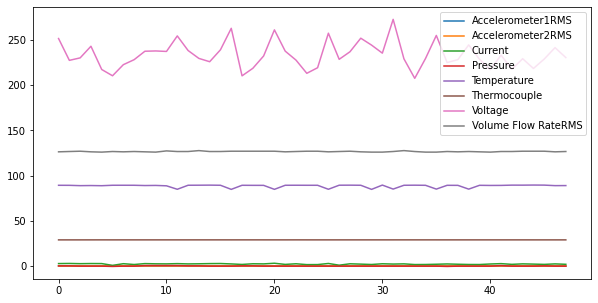

Data with anomalies - true labels


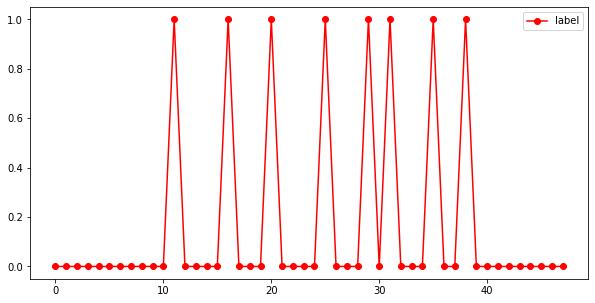

loss celkovo:  0.1439549966247276
loss celkovo:  0.12301201927494024
loss celkovo:  0.12301189091459147
loss celkovo:  0.12301175834230649
loss celkovo:  0.12301162729544818
final loss:  0.12120623606721648
[[-1.43512666 0.605916321]
 [-0.0583721399 1.01428056]
 [0.747235775 0.672405303]
 ...
 [-1.82490778 2.03367472]
 [-3.52974343 1.82084131]
 [-2.40052795 0.572221518]]
sample


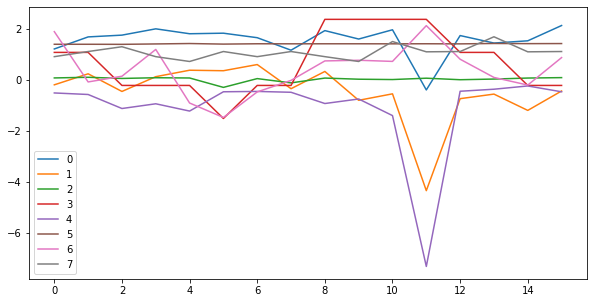

generated_sample


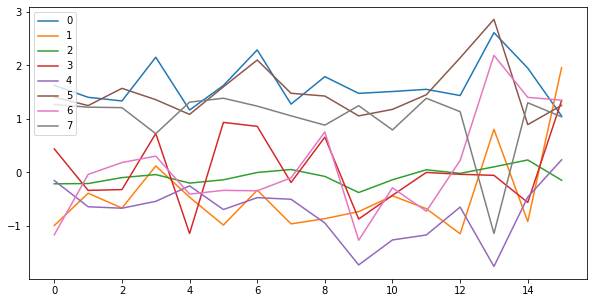

residuals: 
tf.Tensor(
[ 5.93605346  2.97068641  1.63518758  2.73460283  5.07031647  6.00403799
  3.88097871  1.15110041  3.23951239  7.71153439  5.5687551  17.3226351
  3.36813537 11.5064395   3.7744989   6.68267273], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6945584], shape=(1,), dtype=float32)
loss celkovo:  0.26918913428006808
loss celkovo:  0.24044518303253887
loss celkovo:  0.2382490298112914
loss celkovo:  0.23555476340009449
loss celkovo:  0.23539031048002948
final loss:  0.23711686106710345
[[-0.414349854 -0.26236251]
 [-0.692031562 0.272895694]
 [0.292630911 0.293250352]
 ...
 [-1.45096374 2.64281392]
 [7.58182764 -0.646688581]
 [-3.36809087 0.857379317]]
sample


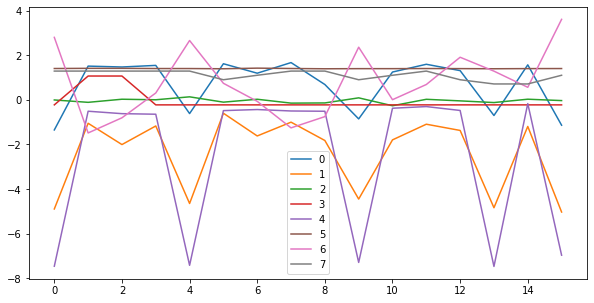

generated_sample


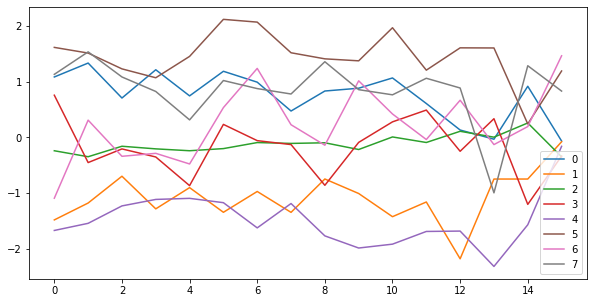

residuals: 
tf.Tensor(
[17.12743159  5.2329159   4.99946144  2.63049172 16.61937466  3.47206161
  4.50938897  4.47477031  3.8564251  12.34925427  4.19411722  4.41888513
  4.83237706 13.94688274  5.80608962 15.88953737], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6195867], shape=(1,), dtype=float32)
loss celkovo:  0.18569302153619427
loss celkovo:  0.13782027078611492
loss celkovo:  0.13781943910420794
loss celkovo:  0.13781866065564113
loss celkovo:  0.13781791680040303
final loss:  0.13776065227848522
[[-1.98891103 0.55162853]
 [1.90241706 -1.35202384]
 [-0.499748 0.346093029]
 ...
 [-1.32403111 -1.27579784]
 [0.0439614356 3.08586025]
 [-2.02848554 1.38351846]]
sample


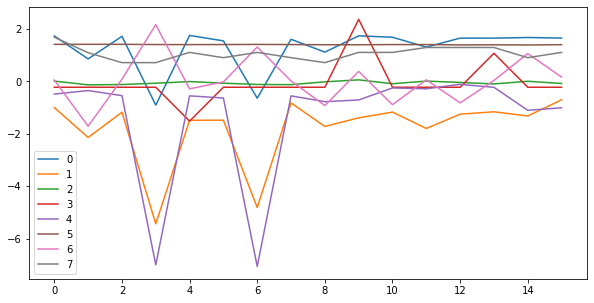

generated_sample


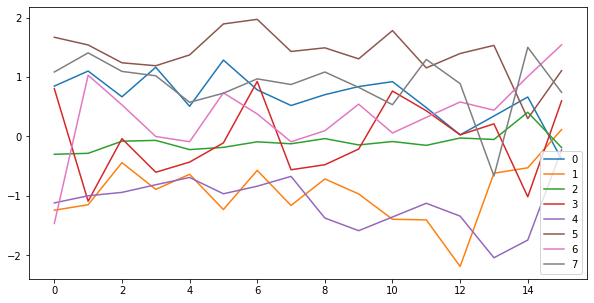

residuals: 
tf.Tensor(
[ 5.46393469  6.08496172  3.41560216 15.86277149  4.27711916  2.48884164
 14.695341    2.03292976  3.7696087   5.49774156  4.97538564  3.38706146
  5.86063323  7.0681496   5.36641402  6.59573419], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.73747987], shape=(1,), dtype=float32)
cross_entropy
0     1.138073
1     0.493515
2    -0.030135
3     0.418725
4     0.988752
5     1.148906
6     0.738699
7    -0.317082
8     0.572378
9     1.388414
10    1.077422
11    2.176346
12    0.608019
13    1.775959
14    0.712935
15    1.251064
16    2.169502
17    1.031997
18    0.989518
19    0.409094
20    2.140054
21    0.655569
22    0.894005
23    0.886900
24    0.750670
25    1.850788
26    0.827357
27    0.875323
28    0.957968
29    1.969019
30    1.129223
31    2.096173
32    1.051949
33    1.154911
34    0.609255
35    2.087242
36    0.819700
37    0.318949
38    2.012090
39    0.137782
40    0.701147
41    1.057836
42    0.962775
43    0.601465
44    1.118930
45

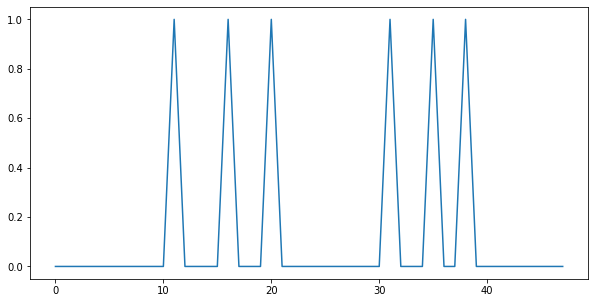

In [16]:
# more than one window
print('Data with anomalies')
window = pd.DataFrame(df_with_anomalies[i:i+window_size*3])
window.plot(figsize=(10,5))
plt.show()

print('Data with anomalies - true labels')
window = pd.DataFrame(df_anomalies_labels[i:i+window_size*3])
window.plot(color='red', marker='o', figsize=(10,5))
plt.show()

anomaly = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[i:i+window_size*3]), treshold = 2)
print('Data with anomalies - resulted labels')
anomaly.plot(figsize=(10,5))
plt.show()